In [1]:
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
import sacc

In [2]:
class ConcentrationDuffy08M500c(ccl.halos.Concentration):
    """ Concentration-mass relation by Duffy et al. 2008                                                                                                                                                           
    (arXiv:0804.2486) extended to Delta = 500-critical.                                                                                                                                                            
    Args:                                                                                                                                                                                                          
        mdef (:class:`~pyccl.halos.massdef.MassDef`): a mass                                                                                                                                                       
            definition object that fixes                                                                                                                                                                           
            the mass definition used by this c(M)                                                                                                                                                                  
            parametrization.                                                                                                                                                                                       
    """
    name = 'Duffy08M500c'

    def __init__(self, mdef=None):
        super(ConcentrationDuffy08M500c, self).__init__(mdef)

    def _default_mdef(self):
        self.mdef = ccl.halos.MassDef(500, 'critical')

    def _check_mdef(self, mdef):
        if (mdef.Delta != 500) or (mdef.rho_type != 'critical'):
            return True
        return False

    def _setup(self):
        self.A = 3.67
        self.B = -0.0903
        self.C = -0.51

    def _concentration(self, cosmo, M, a):
        M_pivot_inv = cosmo.cosmo.params.h * 5E-13
        return self.A * (M * M_pivot_inv)**self.B * a**(-self.C)


In [3]:
pars = {'LOWZ__0': {'sigma8': 0.92172936,
  'ygk_Ahmc': 1.3588493,
  'ygk_LOWZ__0_lM1_0': 13.3611,
  'ygk_LOWZ__0_lMmin_0': 12.042741,
  'ygk_mass_bias': 0.55590708,
  'ygk_rhogy': -0.32790508,
  'chi2': 15.838531},

 'LOWZ__1': {'sigma8': 0.7919121,
  'ygk_Ahmc': 1.1809284,
  'ygk_LOWZ__1_lM1_0': 12.914264,
  'ygk_LOWZ__1_lMmin_0': 11.600737,
  'ygk_mass_bias': 0.79718099,
  'ygk_rhogy': -0.54090419,
  'chi2': 71.889659},

 'LOWZ__2': {'sigma8': 0.78465796,
  'ygk_Ahmc': 1.107181,
  'ygk_LOWZ__2_lM1_0': 13.117914,
  'ygk_LOWZ__2_lMmin_0': 11.850546,
  'ygk_mass_bias': 0.79586005,
  'ygk_rhogy': -0.50491894,
  'chi2': 60.16168},

 'LOWZ__3': {'sigma8': 0.752489,
  'ygk_Ahmc': 1.3309842,
  'ygk_LOWZ__3_lM1_0': 13.301291,
  'ygk_LOWZ__3_lMmin_0': 12.037587,
  'ygk_mass_bias': 0.89429404,
  'ygk_rhogy': -0.53743312,
  'chi2': 82.461938},

 'LOWZ__4': {'sigma8': 0.68715227,
  'ygk_Ahmc': 1.3575118,
  'ygk_LOWZ__4_lM1_0': 13.3019,
  'ygk_LOWZ__4_lMmin_0': 12.098904,
  'ygk_mass_bias': 1.1057704,
  'ygk_rhogy': -0.46596135,
  'chi2': 54.905689},

 'LOWZ__5': {'sigma8': 0.82022833,
  'ygk_Ahmc': 0.89778687,
  'ygk_LOWZ__5_lM1_0': 13.043897,
  'ygk_LOWZ__5_lMmin_0': 12.103436,
  'ygk_mass_bias': 0.75915029,
  'ygk_rhogy': -0.5658599,
  'chi2': 73.209406}}

In [4]:
s = sacc.Sacc.load_fits("../data/1024_yxgxk_covmix/cls_cov_jks.fits")
cov_JK = s.covariance.covmat.copy()
s = sacc.Sacc.load_fits("../data/1024_yxgxk_covdata/cls_cov.fits")
cov_G = s.covariance.covmat.copy()

In [5]:
cov_cNG = np.zeros_like(cov_G)

In [6]:
def cov2r(cov):
    e = np.sqrt(np.diag(cov))
    return cov/(e[:, None]*e[None, :])

In [7]:
def get_trispec_covars(tracer):
    print(tracer)
    fsky = 0.68
    cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.67, n_s=0.96, sigma8=pars[tracer]['sigma8'])
    z = s.tracers[tracer].z
    nz = s.tracers[tracer].nz
    nz[0] = 0
    lMmin = pars[tracer][f'ygk_{tracer}_lMmin_0']
    lM1 = pars[tracer][f'ygk_{tracer}_lM1_0']
    omb = pars[tracer][f'ygk_mass_bias']
    rho = pars[tracer][f'ygk_rhogy']
    lkarr = np.log(np.geomspace(1E-4, 1E2, 256))
    aarr = 1./(1+np.linspace(0, 0.4, 16)[::-1])
    massdef = ccl.halos.MassDef(500, 'critical')
    mfc = ccl.halos.mass_function_from_name('Tinker08')
    mf = mfc(cosmo, mass_def=massdef)
    hbc = ccl.halos.halo_bias_from_name('Tinker10')
    hb = hbc(cosmo, mass_def=massdef)
    cm = ConcentrationDuffy08M500c(mdef=massdef)
    p_g = {'name': 'g',
           'prof': ccl.halos.HaloProfileHOD(cm, lMmin_0=lMmin, lM0_0=lMmin, lM1_0=lM1, siglM_0=0.345),
           'tr': ccl.NumberCountsTracer(cosmo, False, dndz=(z, nz), bias=(z, np.ones_like(z))),
           'norm': True}
    p_k = {'name': 'k',
           'prof': ccl.halos.HaloProfileNFW(cm),
           'tr': ccl.CMBLensingTracer(cosmo, z_source=1100.),
           'norm': True}
    p_y = {'name': 'y',
           'prof': ccl.halos.HaloProfilePressureGNFW(mass_bias=omb),
           'tr': ccl.tSZTracer(cosmo, z_max=3.),
           'norm': False}
    p2_gg = ccl.halos.Profile2ptHOD()
    p2_gy = ccl.halos.Profile2pt(r_corr=rho)
    p2_gk = ccl.halos.Profile2pt()
    hmc = ccl.halos.HMCalculator(cosmo, mf, hb, massdef)
    ls, _, cov_gg, id_gg = s.get_ell_cl('cl_00', tracer, tracer, return_cov=True, return_ind=True)
    ls, _, cov_gk, id_gk = s.get_ell_cl('cl_00', tracer, 'KAPPA', return_cov=True, return_ind=True)
    ls, _, cov_gy, id_gy = s.get_ell_cl('cl_00', tracer, 'YMILCA', return_cov=True, return_ind=True)
    def get_cov(p1, p2, p3, p4, p12, p34):
        print(p1['name'], p2['name'], p3['name'], p4['name'])
        tkk = ccl.halos.halomod_Tk3D_1h(cosmo, hmc,
                                        prof1=p1['prof'],
                                        prof2=p2['prof'],
                                        prof3=p3['prof'],
                                        prof4=p4['prof'],
                                        prof12_2pt=p12,
                                        prof34_2pt=p34,
                                        normprof1=p1['norm'],
                                        normprof2=p2['norm'],
                                        normprof3=p3['norm'],
                                        normprof4=p4['norm'],
                                        a_arr=aarr, lk_arr=lkarr)
        cov = ccl.angular_cl_cov_cNG(cosmo,
                                     cltracer1=p1['tr'],
                                     cltracer2=p2['tr'],
                                     cltracer3=p3['tr'],
                                     cltracer4=p4['tr'],
                                     ell=ls, ell2=ls,
                                     tkka=tkk, fsky=fsky,
                                     integration_method='spline')
        return cov
    cov_gggg = get_cov(p_g, p_g, p_g, p_g, p2_gg, p2_gg)
    cov_gggy = get_cov(p_g, p_g, p_g, p_y, p2_gg, p2_gy)
    cov_gggk = get_cov(p_g, p_g, p_g, p_k, p2_gg, p2_gk)
    cov_gygy = get_cov(p_g, p_y, p_g, p_y, p2_gy, p2_gy)
    cov_gygk = get_cov(p_g, p_y, p_g, p_k, p2_gy, p2_gk)
    cov_gkgk = get_cov(p_g, p_k, p_g, p_k, p2_gk, p2_gk)
    cov_cNG[np.ix_(id_gg, id_gg)] = cov_gggg
    cov_cNG[np.ix_(id_gg, id_gy)] = cov_gggy
    cov_cNG[np.ix_(id_gg, id_gk)] = cov_gggk
    cov_cNG[np.ix_(id_gy, id_gg)] = cov_gggy.T
    cov_cNG[np.ix_(id_gy, id_gy)] = cov_gygy
    cov_cNG[np.ix_(id_gy, id_gk)] = cov_gygk
    cov_cNG[np.ix_(id_gk, id_gg)] = cov_gggk.T
    cov_cNG[np.ix_(id_gk, id_gy)] = cov_gygk.T
    cov_cNG[np.ix_(id_gk, id_gk)] = cov_gggk

for i in range(6):
    get_trispec_covars(f'LOWZ__{i}')

LOWZ__0
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k
LOWZ__1
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k
LOWZ__2
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k
LOWZ__3
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k
LOWZ__4
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k
LOWZ__5
g g g g
g g g y
g g g k
g y g y
g y g k
g k g k


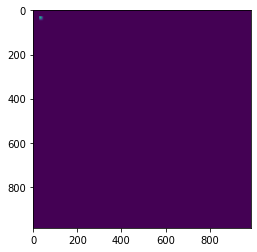

In [8]:
plt.imshow(cov_cNG)

In [9]:
cov_M = cov_G+cov_cNG

In [10]:
diag = np.maximum(np.diag(cov_M), np.diag(cov_JK))
rij = cov2r(cov_M)
cov_comb = rij*np.sqrt(diag[None, :]*diag[:, None])

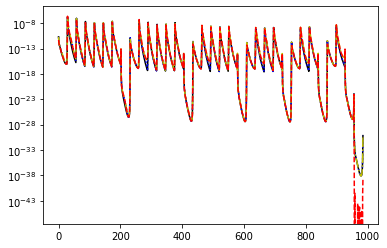

In [11]:
plt.plot(np.diag(cov_G), 'k-')
plt.plot(np.diag(cov_M), 'b:')
plt.plot(np.diag(cov_comb), 'y-.')
plt.plot(np.diag(cov_JK), 'r--')
plt.yscale('log')

<ipython-input-12-7f7104b60db9>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


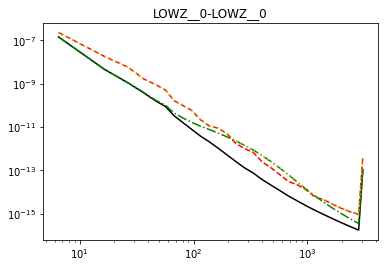

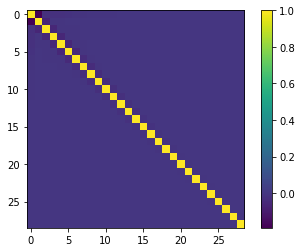

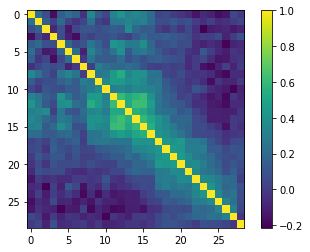

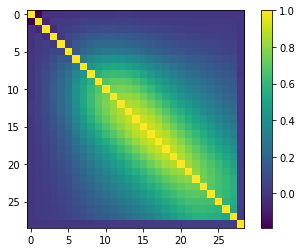

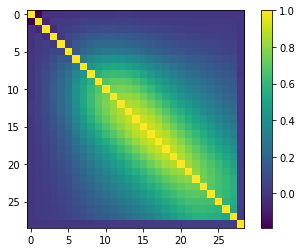

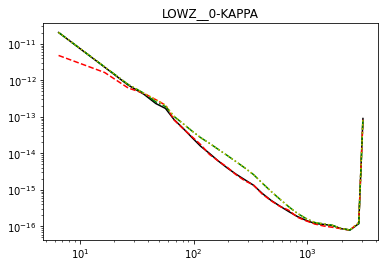

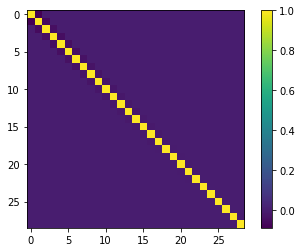

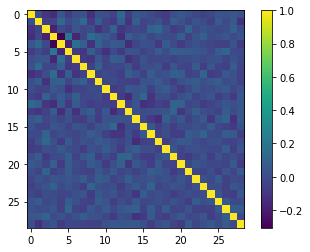

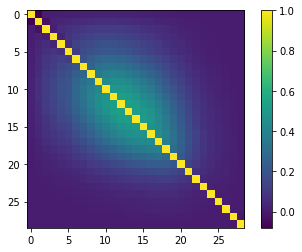

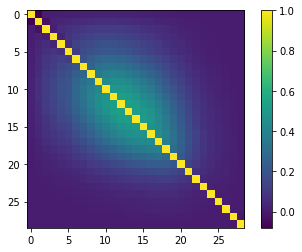

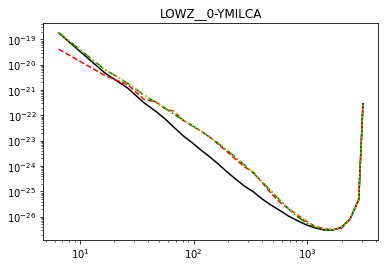

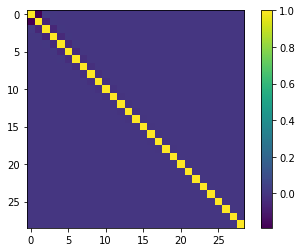

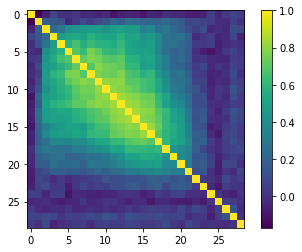

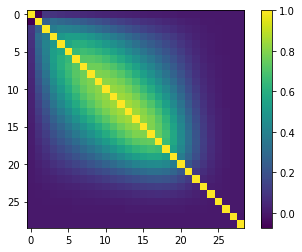

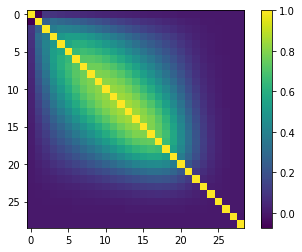

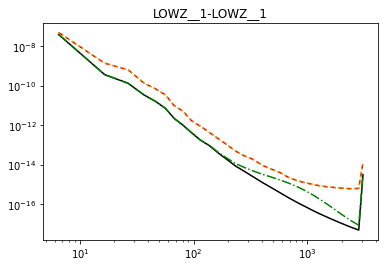

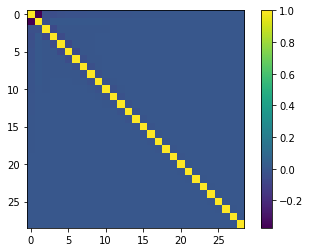

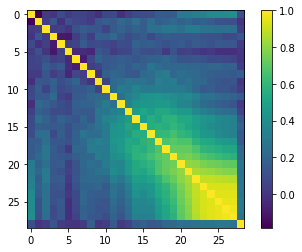

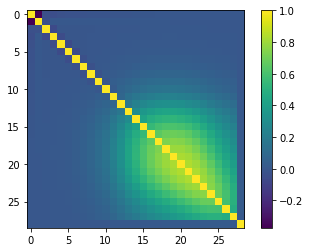

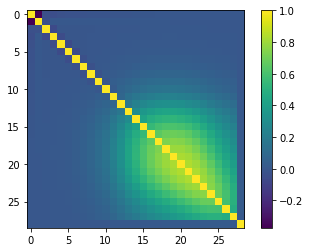

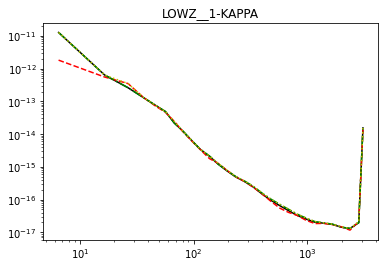

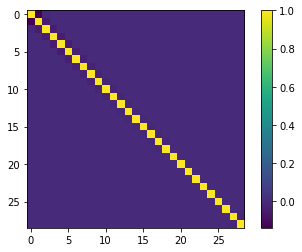

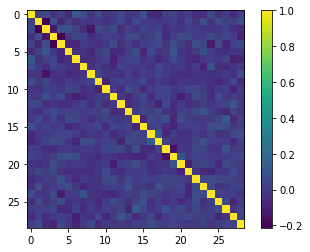

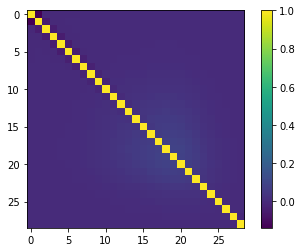

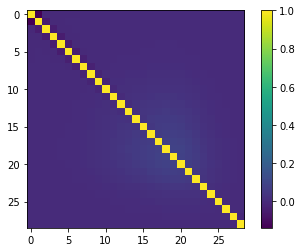

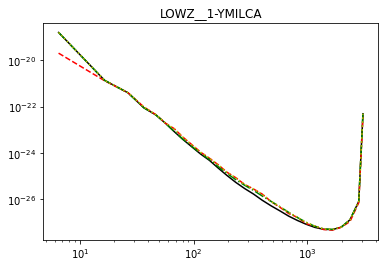

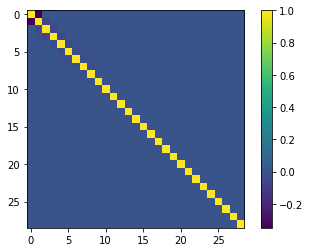

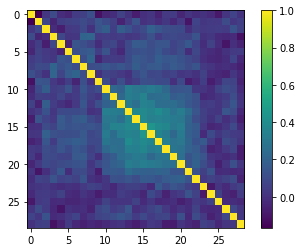

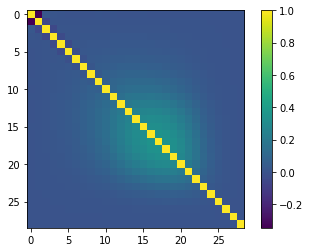

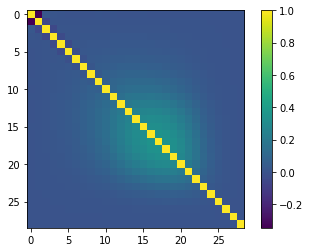

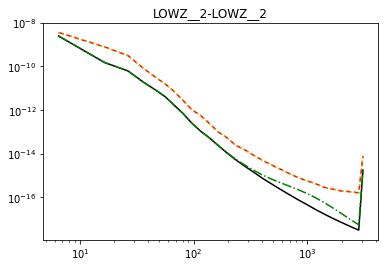

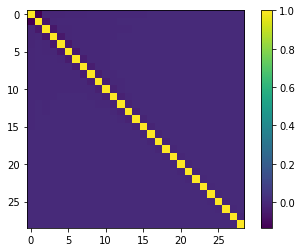

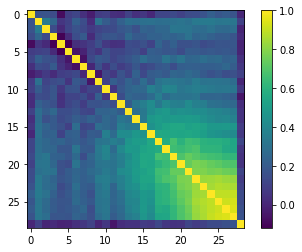

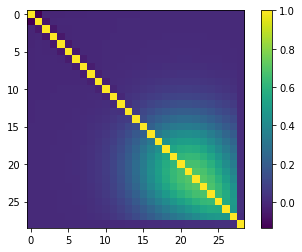

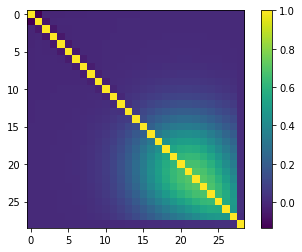

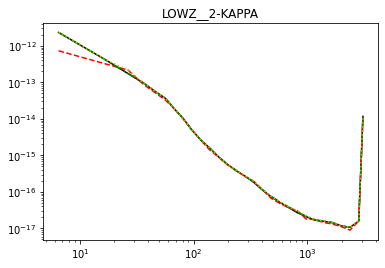

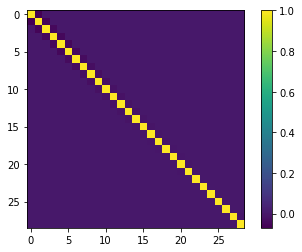

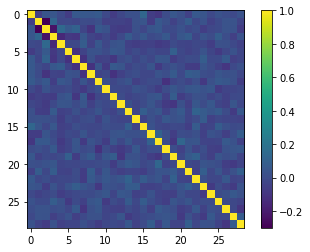

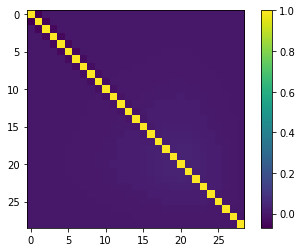

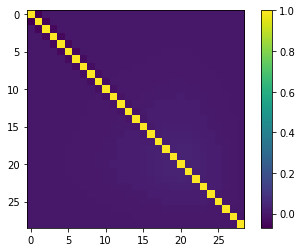

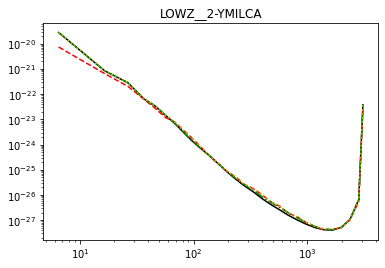

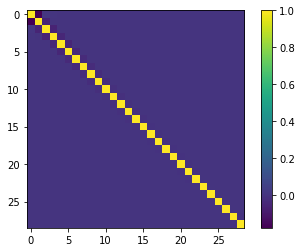

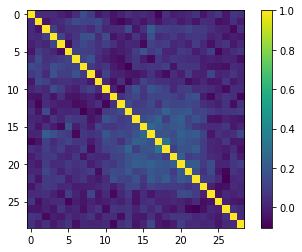

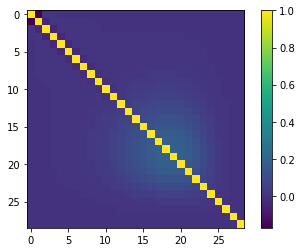

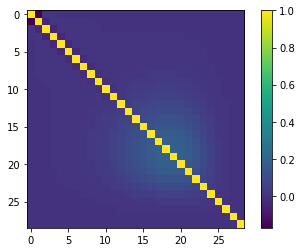

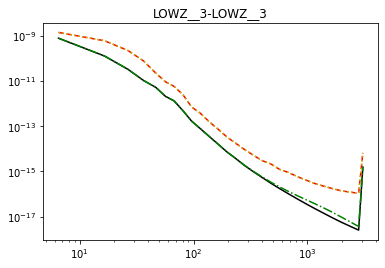

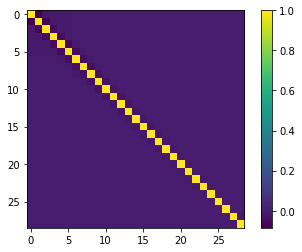

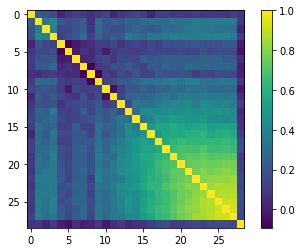

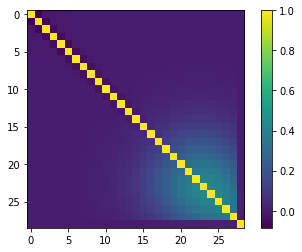

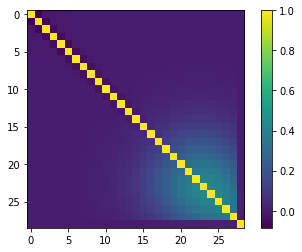

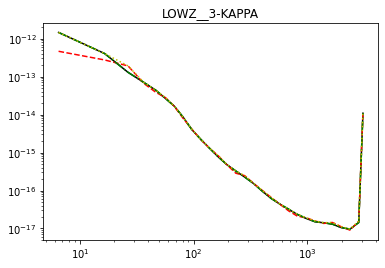

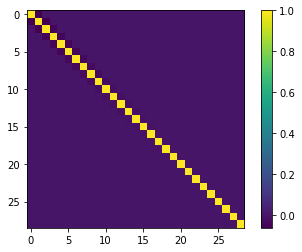

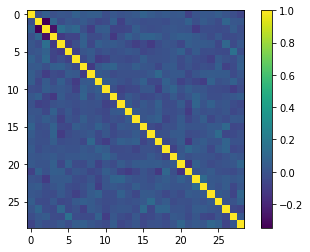

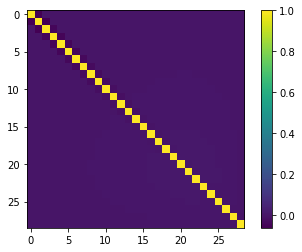

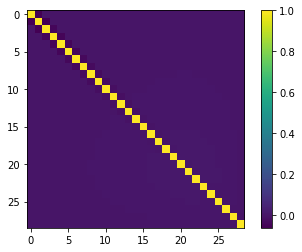

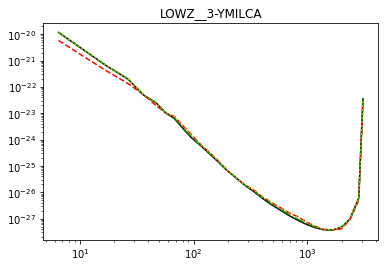

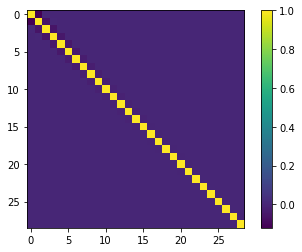

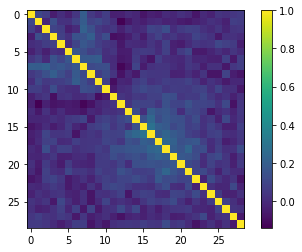

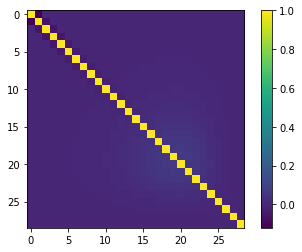

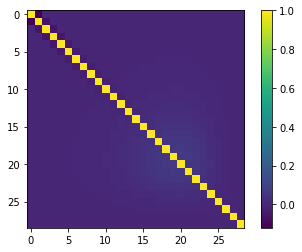

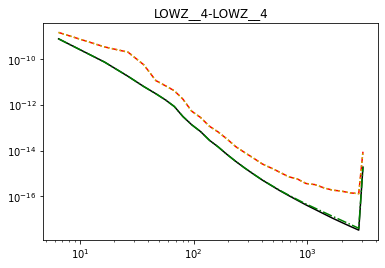

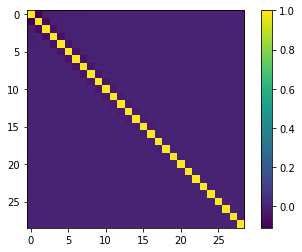

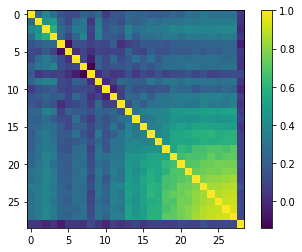

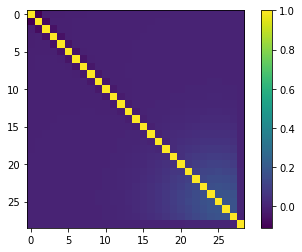

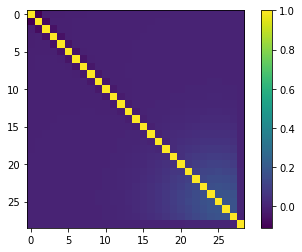

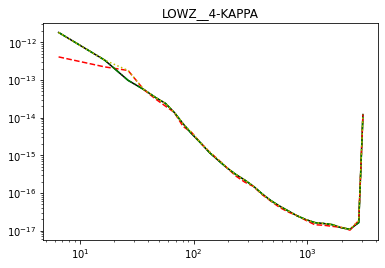

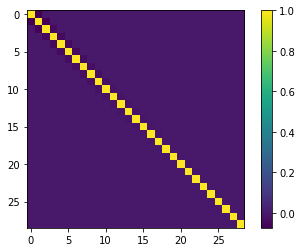

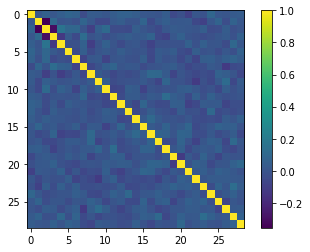

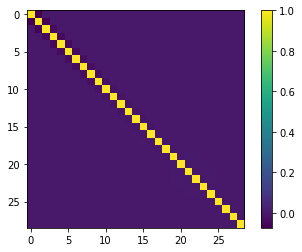

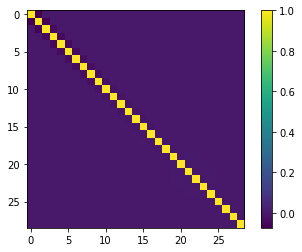

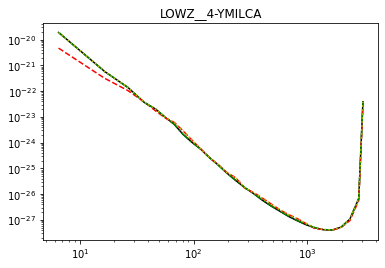

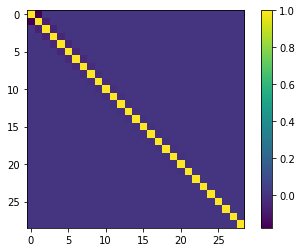

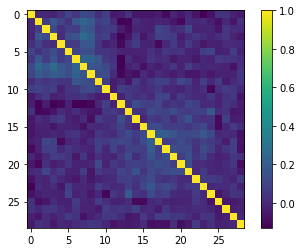

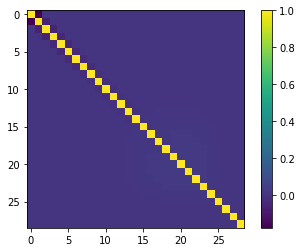

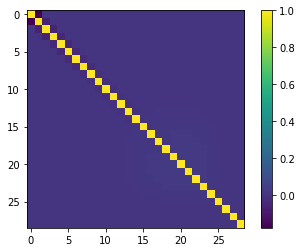

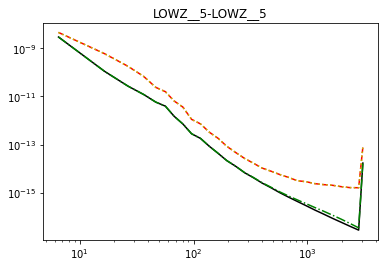

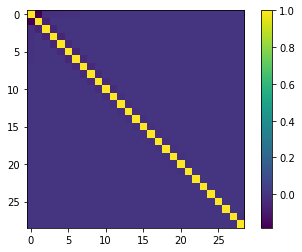

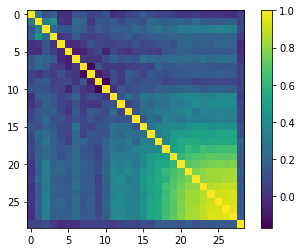

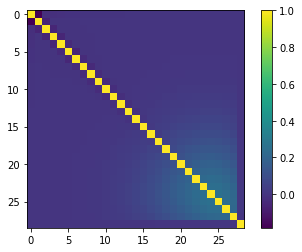

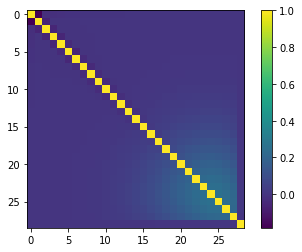

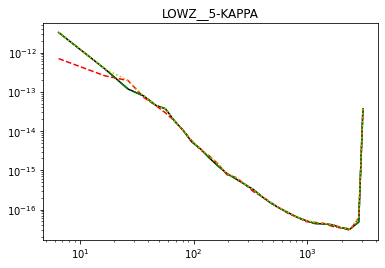

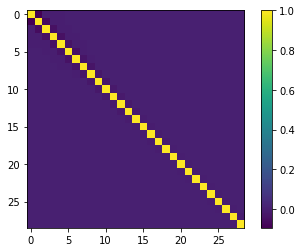

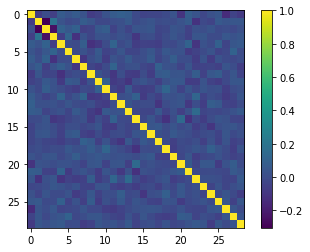

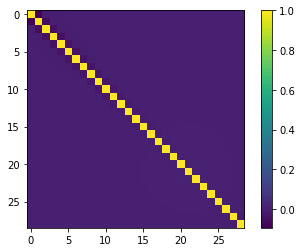

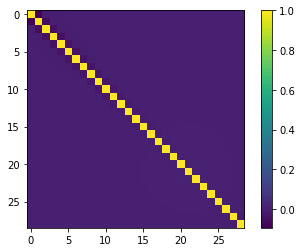

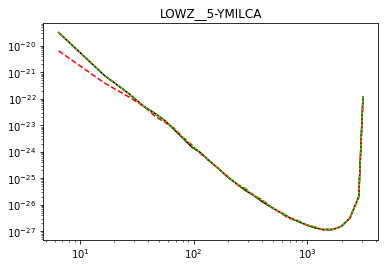

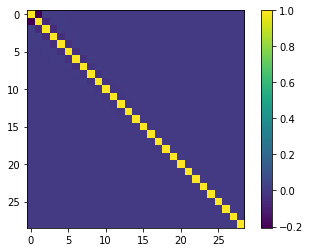

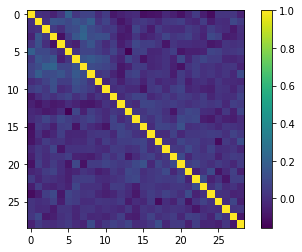

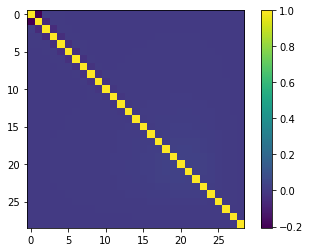

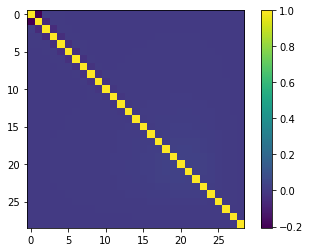

In [12]:
def comp_cov(tr1):
    for tr2 in [tr1, 'KAPPA', 'YMILCA']:
        ls, _, ids = s.get_ell_cl('cl_00', tr1, tr2, return_ind=True)
        plt.figure()
        plt.title(f'{tr1}-{tr2}')
        plt.plot(ls, np.diag(cov_G)[ids], 'k-')
        plt.plot(ls, np.diag(cov_JK)[ids], 'r--')
        plt.plot(ls, np.diag(cov_M)[ids], 'g-.')
        plt.plot(ls, np.diag(cov_comb)[ids], 'y:')
        plt.loglog()
        plt.figure(); plt.imshow(cov2r(cov_G[ids][:, ids])); plt.colorbar()
        plt.figure(); plt.imshow(cov2r(cov_JK[ids][:, ids])); plt.colorbar()
        plt.figure(); plt.imshow(cov2r(cov_M[ids][:, ids])); plt.colorbar()
        plt.figure(); plt.imshow(cov2r(cov_comb[ids][:, ids])); plt.colorbar()
comp_cov('LOWZ__0')
comp_cov('LOWZ__1')
comp_cov('LOWZ__2')
comp_cov('LOWZ__3')
comp_cov('LOWZ__4')
comp_cov('LOWZ__5')

In [16]:
s.covariance.covmat = cov_comb
s.save_fits('cls_cov_new.fits')